#Different approaches for Code Smells detection

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
!pip install torch

In [4]:
!git clone https://github.com/bentrevett/code2vec.git

fatal: destination path 'code2vec' already exists and is not an empty directory.


In [5]:
# Import delle librerie necessarie
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
import nltk
import re
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch as pt
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, jaccard_score, hamming_loss, f1_score, confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/code smells tesi/projects"
projects = []
code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
# Itera su tutti i file e le cartelle nella cartella specificata
for item in os.listdir(path):
    # Se l'elemento nella cartella è una cartella, aggiungi il nome alla lista
    if os.path.isdir(os.path.join(path, item)):
       projects.append(item)
    # Stampa la lista di nomi dei progetti
print(projects)

['ant-ivy-2.0.0-alpha2', 'ant-rel-1.8.3', 'cassandra-cassandra-1.0.0', 'elasticsearch-v0.19.0', 'hadoop-release-0.6.0', 'hive-release-0.9.0', 'hsqldb-2.2.8', 'karaf-karaf-2.3.0', 'lucene-releases-lucene-solr-3.6.0', 'manifold-cf-release-0.6', 'nutch-release-1.4', 'pig-release-0.8.0', 'qpid-0.14', 'struts-STRUTS_2_3_4', 'xerces2-j-Xerces-J_2_3_0']


In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/dataset/ultimate_dataset.csv")

In [8]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,"/*\n * The Apache Software License, Version 1....",4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,// XMLFilterImpl.java - base SAX2 filter imple...,14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,// XMLReaderAdapter.java - adapt an SAX2 XMLRe...,15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,// XMLReaderFactory.java - factory for creatin...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


In [9]:
print(len(df['Component'][1]))

22488


##Data Preparation

###Identification ed elimination of stop words

In [10]:
# nltk.download('stopwords')

# stop_words = set(stopwords.words('english'))

# def remove_comments(code):
#     # Rimuove i commenti su una singola riga
#     code = re.sub(r'//.*', '', code)
#     # Rimuove i commenti su più righe
#     code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
#     # Rimuove le stopwords
#     tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
#     filtered_text = ' '.join(tokens)
#     # Rimuoviamo gli import
#     code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
#     # Rimuoviamo i package
#     code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
#     #Rimuove \n e \t
#     code = re.sub(r'[\n\t]', '', code)
#     return code

# for i in range(len(df)):
#     df['Component'][i] = remove_comments(df['Component'][i])

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Aggiungi stopwords specifiche per Java
java_stopwords = [
    'java', 'protected', 'class', 'interface', 'package',
    'import', 'static', 'void', 'new', 'return', 'extends', 'implements', 'null',
    'try', 'catch', 'finally', 'throw', 'throws'
]

stop_words.update(java_stopwords)

def remove_comments(code):
    # Rimuove i commenti su una singola riga
    code = re.sub(r'//.*', '', code)
    # Rimuove i commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Rimuoviamo gli import
    code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuoviamo i package
    code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuove \n e \t
    code = re.sub(r'[\n\t]', '', code)
    # Rimuove le stopwords solo se sono parole singole
    tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
    filtered_text = ' '.join(tokens)
    return filtered_text

for i in range(len(df)):
    df['Component'][i] = remove_comments(df['Component'][i])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-10-41149e01540a>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Component'][i] = remove_comments(df['Component'][i])


####Dataset after the elimination of stop words:

In [11]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,public ivy { private final int kilo = 1024; pu...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,public ivy14 { private ivy ivy; public ivy14()...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,public final main { private final int dependen...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,public addpathtask task { private string topat...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,public antbuildtrigger abstracttrigger trigger...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,securitysupport12 securitysupport { public cla...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,"public xmlfilterimpl xmlfilter, entityresolver...",14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,"public xmlreaderadapter parser, contenthandler...",15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,final public xmlreaderfactory { private xmlrea...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


In [12]:
print(len(df['Component'][1]))

15530


###Data Cleaning
There are NaN (Not a Number) values present, to avoid classification issues, it preferable to remove the instances containing missing data as they are present in small quantities.

In [13]:
df.isnull().sum()

Project_name      0
Component         0
CBO               0
CYCLO             0
DIT               0
ELOC              0
FanIn             0
FanOut            0
LCOM              0
LOC               0
LOCNAMM           0
NOA               0
NOC               0
NOM               0
NOMNAMM           0
NOPA              0
PMMM              0
PRB               0
WLOCNAMM        245
WMC               0
WMCNAMM           0
NMNOPARAM         0
CDSBP             0
CC                0
LC                0
LZC               0
RB                0
SC                0
dtype: int64

In [14]:
df.dropna(inplace=True)

####Dataset after the data cleaning operation:

In [15]:
df.isnull().sum()

Project_name    0
Component       0
CBO             0
CYCLO           0
DIT             0
ELOC            0
FanIn           0
FanOut          0
LCOM            0
LOC             0
LOCNAMM         0
NOA             0
NOC             0
NOM             0
NOMNAMM         0
NOPA            0
PMMM            0
PRB             0
WLOCNAMM        0
WMC             0
WMCNAMM         0
NMNOPARAM       0
CDSBP           0
CC              0
LC              0
LZC             0
RB              0
SC              0
dtype: int64

In [16]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,public ivy { private final int kilo = 1024; pu...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,public ivy14 { private ivy ivy; public ivy14()...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,public final main { private final int dependen...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,public addpathtask task { private string topat...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,public antbuildtrigger abstracttrigger trigger...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,securitysupport12 securitysupport { public cla...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,"public xmlfilterimpl xmlfilter, entityresolver...",14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,"public xmlreaderadapter parser, contenthandler...",15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,final public xmlreaderfactory { private xmlrea...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


###Data Balancing

####The dependent variables that the models will need to predict are 6: CDSBP, CC, LC, LZC, RB, SC. Let's analyze the distribution of each label to quantify how balanced the dataset is with the dependent variable.

####Complex Class:

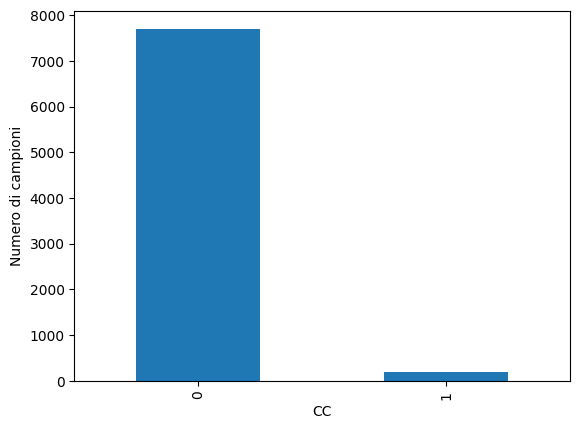

In [17]:
# sns.histplot(df['CC'], legend=True, color='yellow')


# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['CC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('CC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()



####Class Data Should Be Private

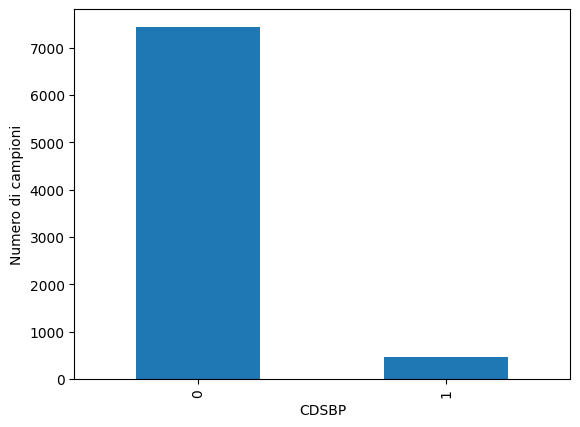

In [18]:
# sns.histplot(df['CDSBP'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['CDSBP'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('CDSBP')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Large Class

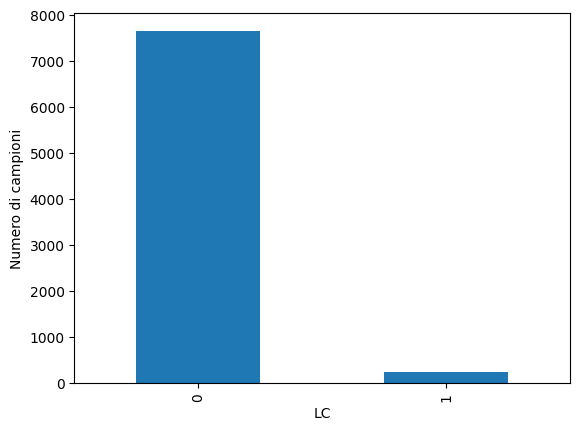

In [19]:
# sns.histplot(df['LC'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['LC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('LC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Lazy Class

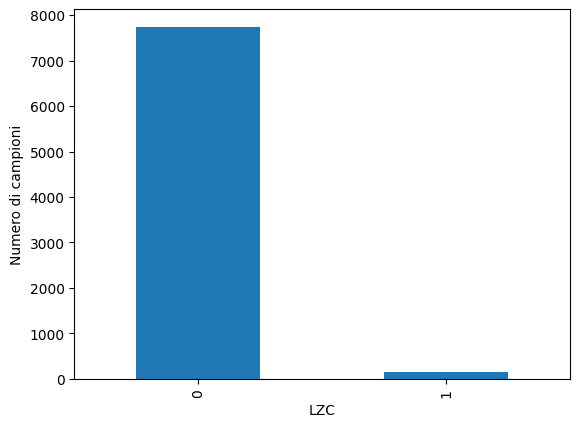

In [20]:
# sns.histplot(df['LZC'], legend=True, color='yellow')
# sns.histplot(df['CDSBP'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['LZC'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('LZC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Refused Bequest

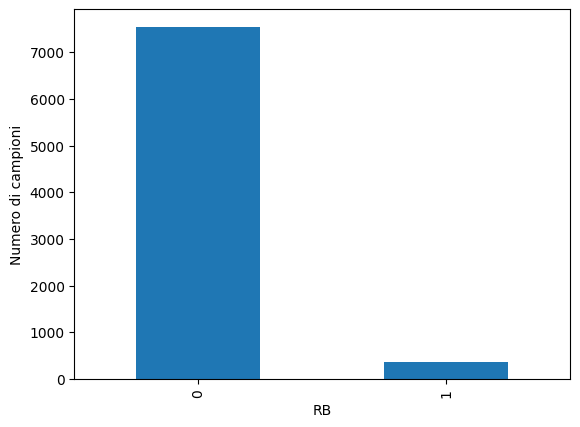

In [21]:
# sns.histplot(df['RB'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['RB'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('RB')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()

####Spaghetti Code

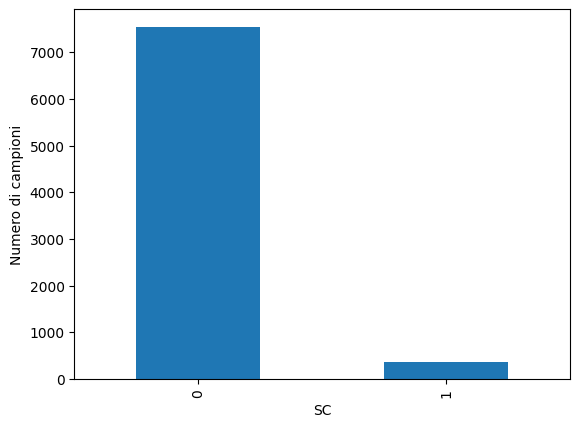

In [22]:
# sns.histplot(df['SC'], legend=True, color='yellow')

# Calcola la distribuzione delle etichette nel dataset
distribuzione_etichette = df['RB'].value_counts()

# Crea il diagramma a barre
distribuzione_etichette.plot(kind='bar')

# Aggiungi etichette e titolo al diagramma
plt.xlabel('SC')
plt.ylabel('Numero di campioni')

# Mostra il diagramma a barre
plt.show()


####The dataset is highly unbalanced, but to avoid the introducing of overfitting or underfitting, after extensive research, it has been decided to avoid the balancing the dataset.

In [23]:
def reduce_dataset(dataset):
    # Seleziona le istanze in cui almeno una delle etichette è pari a 1
    non_zero_dataset = dataset.loc[(dataset['CDSBP'] == 1) | (dataset['CC'] == 1) | (dataset['LC'] == 1) | (dataset['LZC'] == 1) | (dataset['RB'] == 1) | (dataset['SC'] == 1)]

    # Seleziona casualmente 4000 - N istanze con tutte le etichette pari a 0
    zero_dataset = dataset.loc[(dataset['CDSBP'] == 0) & (dataset['CC'] == 0) & (dataset['LC'] == 0) & (dataset['LZC'] == 0) & (dataset['RB'] == 0) & (dataset['SC'] == 0)]
    zero_samples = min(4000 - len(non_zero_dataset), len(zero_dataset))
    zero_dataset = zero_dataset.sample(n=zero_samples, replace=False, random_state=42)

    # Concatena le istanze con almeno una etichetta pari a 1 e le istanze con tutte le etichette pari a 0
    reduced_dataset = pd.concat([non_zero_dataset, zero_dataset])

    # Mischia casualmente le righe del dataset ridotto
    reduced_dataset = reduced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    return reduced_dataset


In [24]:
reduced_dataset = reduce_dataset(df)

In [25]:
reduced_dataset

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-rel-1.8.3,public weblogicdeploymenttool genericdeploymen...,22.0,83.0,2.0,622.0,4.0,115.0,413.0,622.0,...,17.827586,83.0,0.0,5.0,0,0,0,0,1,0
1,elasticsearch-v0.19.0,public snapshotfailedengineexception engineexc...,1.0,1.0,2.0,7.0,2.0,0.0,0.0,7.0,...,3.000000,1.0,0.0,0.0,0,0,0,0,0,0
2,ant-rel-1.8.3,public jonasdeploymenttool genericdeploymentto...,10.0,72.0,2.0,566.0,3.0,83.0,295.0,566.0,...,16.407407,72.0,0.0,2.0,0,0,0,0,1,0
3,pig-release-0.8.0,public nativemapreduceoper mapreduceoper { pri...,7.0,21.0,2.0,66.0,17.0,12.0,8.0,66.0,...,8.833333,21.0,0.0,6.0,0,0,0,0,0,0
4,elasticsearch-v0.19.0,public abstract networkutils { private final e...,8.0,70.0,1.0,184.0,30.0,41.0,78.0,184.0,...,11.133333,70.0,0.0,10.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,hadoop-release-0.6.0,public identityreducer mapreducebase reducer {...,8.0,3.0,2.0,13.0,5.0,3.0,0.0,13.0,...,8.000000,3.0,0.0,0.0,0,0,0,1,0,0
3996,hsqldb-2.2.8,public rowavldisk rowavl { public final int no...,9.0,65.0,2.0,229.0,44.0,21.0,287.0,229.0,...,8.040000,65.0,0.0,9.0,0,0,0,0,1,0
3997,ant-rel-1.8.3,public zipfile { private final int hash_size =...,15.0,89.0,1.0,478.0,139.0,77.0,144.0,478.0,...,18.000000,89.0,0.0,7.0,0,0,0,0,0,1
3998,hsqldb-2.2.8,public jdbcpooleddatasource jdbccommondatasour...,13.0,10.0,2.0,33.0,15.0,9.0,3.0,33.0,...,8.333333,10.0,0.0,2.0,0,0,0,0,0,0


##In this section, will be presented various models, their implementations and the metrics that will be used in the final test to understand which model and which approach works best for identifying code smells.

In [26]:
def get_class_embedding(class_text, word2vec_model):
    words = str(class_text).split()
    embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return None

In [27]:
def train_random_forest(X_train, Y_train, X_test, Y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)

    precision = precision_score(Y_test, y_pred, average='macro')
    accuracy = accuracy_score(Y_test, y_pred)
    mcc = matthews_corrcoef(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred, average='macro')
    f1 = f1_score(Y_test, y_pred, average='macro')

    return y_pred, precision, accuracy, mcc, recall, f1

In [28]:
def train_word2vec(X_train_comp, X_test_comp, Y_train, Y_test):
    sentences = [str(text).split() for text in X_train_comp]
    word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)

    X_train_embeddings = X_train_comp.apply(lambda x: get_class_embedding(x, word2vec_model)).dropna()
    X_test_embeddings = X_test_comp.apply(lambda x: get_class_embedding(x, word2vec_model)).dropna()

    classifier = RandomForestClassifier()
    classifier.fit(list(X_train_embeddings), Y_train)

    predictions = classifier.predict(list(X_test_embeddings))

    precision = precision_score(Y_test, predictions, average='macro')
    accuracy = accuracy_score(Y_test, predictions)
    mcc = matthews_corrcoef(Y_test, predictions)
    recall = recall_score(Y_test, predictions, average='macro')
    f1 = f1_score(Y_test, predictions, average='macro')

    return predictions, precision, accuracy, mcc, recall, f1

In [29]:
import torch
def train_codebert(X_train_comp, X_test_comp, Y_train, Y_test):
    tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
    model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)

    train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length=512)
    test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length=512)

    batch_size = 8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
    train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

    val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
    val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=1e-5)
    loss_function = nn.BCEWithLogitsLoss()

    model.to(device)
    model.train()

    for epoch in range(3):
        for batch in train_dataloader:
            optimizer.zero_grad()

            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            labels = labels.float()

            outputs = model(inputs)
            logits = outputs.logits

            loss = loss_function(logits.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()

            del inputs, labels
            torch.cuda.empty_cache()

    predictions = []

    for batch in val_dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        val_outputs = model(inputs)
        val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()

        if val_predicted_labels.dim() > 0:
            predictions.extend(val_predicted_labels.cpu().numpy())

        del inputs, labels, val_outputs, val_predicted_labels
        torch.cuda.empty_cache()

    predictions = np.array(predictions)
    test_labels = val_labels.cpu().numpy()

    precision = precision_score(test_labels, predictions, average='macro')
    accuracy = accuracy_score(test_labels, predictions)
    mcc = matthews_corrcoef(test_labels, predictions)
    recall = recall_score(test_labels, predictions, average='macro')
    f1 = f1_score(test_labels, predictions, average='macro')


    return predictions, precision, accuracy, mcc, recall, f1

In [30]:
def main():
    code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
    RF_final_df = pd.DataFrame()
    W2V_final_df = pd.DataFrame()
    CB_final_df = pd.DataFrame()
    RF_Trad_predictions = {}
    RF_metrics = {}
    RF_WTV_predictions = {}
    RF_WTV_metrics = {}
    CB_predictions = {}
    CB_metrics = {}
    

    for project in projects:
        print("Current project:", project)
        project_df = reduced_dataset[reduced_dataset['Project_name'] == project]
        if len(project_df) == 0:
            continue

        RF_Trad_predictions[project] = {}
        RF_metrics[project] = {}
        RF_WTV_predictions[project] = {}
        RF_WTV_metrics[project] = {}
        CB_predictions[project] = {}
        CB_metrics[project] = {}

        for smell in code_smells:
            print("Current code smell:", smell)

            X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC'])
            y = project_df[str(smell)]

            X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=1)

            c = 0
            for x in Y_test:
                if x == 1:
                    c += 1
            if c < 2:
                continue

            X_train_comp = X_train['Component']
            X_test_comp = X_test['Component']

            X_train.drop(columns=['Component', 'Project_name'], inplace=True)
            X_test.drop(columns=['Component', 'Project_name'], inplace=True)

            normalizer = MinMaxScaler()

            X_train_normalized = normalizer.fit_transform(X_train)
            X_test_normalized = normalizer.transform(X_test)

            y_pred, precision, accuracy, mcc, recall, f1 = train_random_forest(X_train_normalized, Y_train,
                                                                                X_test_normalized, Y_test)

            RF_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            RF_Trad_predictions[project][smell] = y_pred

            RF_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [RF_Trad_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            predictions, precision, accuracy, mcc, recall, f1 = train_word2vec(X_train_comp, X_test_comp, Y_train,
                                                                                Y_test)

            RF_WTV_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            RF_WTV_predictions[project][smell] = predictions

            W2V_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [RF_WTV_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            predictions, precision, accuracy, mcc, recall, f1 = train_codebert(X_train_comp, X_test_comp, Y_train,
                                                                               Y_test)

            CB_metrics[project][smell] = {
                "Precision": precision,
                "Accuracy": accuracy,
                "Recall": recall,
                "F1": f1,
                "MCC": mcc
            }
            CB_predictions[project][smell] = predictions

            CB_temp_pred = pd.DataFrame({
                'Project_name': [project],
                'Smell': [smell],
                'Y_pred': [CB_predictions[project][smell].tolist()],
                'Y_test': [Y_test.tolist()],
                'precision': precision,
                'accuracy': accuracy,
                'recall': recall,
                'f1': f1,
                'mcc': mcc,
            })

            RF_final_df = pd.concat([RF_final_df, RF_temp_pred], ignore_index=True)
            W2V_final_df = pd.concat([W2V_final_df, W2V_temp_pred], ignore_index=True)
            CB_final_df = pd.concat([CB_final_df, CB_temp_pred], ignore_index=True)

            predictions_list = [RF_Trad_predictions[project][smell], RF_WTV_predictions[project][smell]]
            predictions_array = np.array(predictions_list)
            _, p_value = friedmanchisquare(*predictions_array.T)

            print("Friedman test p-value for", project, smell, ":", p_value)

    RF_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_result.csv", index=False)
    W2V_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_W2V_results.csv", index=False)
    CB_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/CB_results.csv", index=False)


In [31]:
main()

Current project: ant-ivy-2.0.0-alpha2
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-ivy-2.0.0-alpha2 CDSBP : 3.45493138298474e-05
Current code smell: CC
Current code smell: LC
Current code smell: LZC
Current code smell: RB
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-ivy-2.0.0-alpha2 SC : 3.4549313829847686e-05
Current project: ant-rel-1.8.3
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-rel-1.8.3 CDSBP : 1.0500595360958284e-23
Current code smell: CC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-rel-1.8.3 CC : 4.204901599955384e-25
Current code smell: LC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-rel-1.8.3 LC : 4.204901599958281e-25
Current code smell: LZC
Current code smell: RB


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-rel-1.8.3 RB : 3.7613024969342684e-24
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for ant-rel-1.8.3 SC : 5.941821986244048e-23
Current project: cassandra-cassandra-1.0.0
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for cassandra-cassandra-1.0.0 CDSBP : 7.196578718070726e-06
Current code smell: CC
Current code smell: LC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for cassandra-cassandra-1.0.0 LC : 3.8616995896625773e-07
Current code smell: LZC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Ber

Friedman test p-value for cassandra-cassandra-1.0.0 LZC : nan
Current code smell: RB
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for cassandra-cassandra-1.0.0 SC : 2.0326145327626274e-06
Current project: elasticsearch-v0.19.0
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for elasticsearch-v0.19.0 CDSBP : 6.330666995650518e-12
Current code smell: CC
Current code smell: LC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for elasticsearch-v0.19.0 LC : 1.3059744857411378e-16
Current code smell: LZC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for elasticsearch-v0.19.0 LZC : 1.7990793006382964e-06
Current code smell: RB
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for elasticsearch-v0.19.0 SC : 3.049001926884205e-12
Current project: hadoop-release-0.6.0
Current code smell: CDSBP
Current code smell: CC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hadoop-release-0.6.0 CC : 0.0004141683655120206
Current code smell: LC
Current code smell: LZC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hadoop-release-0.6.0 LZC : 2.125744474729936e-05
Current code smell: RB
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hadoop-release-0.6.0 SC : 0.002283531454611877
Current project: hive-release-0.9.0
Current project: hsqldb-2.2.8
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hsqldb-2.2.8 CDSBP : 5.573920182922897e-19
Current code smell: CC


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForS

Friedman test p-value for hsqldb-2.2.8 CC : 0.4883809327166127
Current code smell: LC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hsqldb-2.2.8 LC : 3.5956411850223543e-19
Current code smell: LZC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hsqldb-2.2.8 LZC : 2.437470923778333e-18
Current code smell: RB


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hsqldb-2.2.8 RB : 5.454163316289124e-15
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for hsqldb-2.2.8 SC : 2.114138222766659e-19
Current project: karaf-karaf-2.3.0
Current project: lucene-releases-lucene-solr-3.6.0
Current project: manifold-cf-release-0.6
Current project: nutch-release-1.4
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for nutch-release-1.4 CDSBP : 0.0021311519191031425
Current code smell: CC
Current code smell: LC
Current code smell: LZC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for nutch-release-1.4 LZC : 0.008455122563919629
Current code smell: RB
Current code smell: SC
Current project: pig-release-0.8.0
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for pig-release-0.8.0 CDSBP : 4.56839994018007e-09
Current code smell: CC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for pig-release-0.8.0 CC : 5.461086768647516e-07
Current code smell: LC
Current code smell: LZC
Current code smell: RB


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for pig-release-0.8.0 RB : 0.00020830282438227292
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for pig-release-0.8.0 SC : 3.5608079007713716e-08
Current project: qpid-0.14
Current project: struts-STRUTS_2_3_4
Current project: xerces2-j-Xerces-J_2_3_0
Current code smell: CDSBP


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 CDSBP : 4.258474518142955e-12
Current code smell: CC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 CC : 3.1788261646358025e-12
Current code smell: LC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 LC : 6.794072679489475e-11
Current code smell: LZC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 LZC : 3.568968795523354e-14
Current code smell: RB


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 RB : 1.2916864120459055e-11
Current code smell: SC


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Friedman test p-value for xerces2-j-Xerces-J_2_3_0 SC : 1.967665996431463e-13


In [32]:
# import torch

# code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']

# # Dataframe per i risultati finali
# RF_final_df = pd.DataFrame()
# W2V_final_df = pd.DataFrame()
# CB_final_df = pd.DataFrame()

# # Dizionario per salvare le predizioni
# RF_Trad_predictions = {}
# RF_WTV_predictions = {}
# CB_predictions = {}

# # Dizionario per salvare le metriche
# RF_metrics = {}
# RF_WTV_metrics = {}
# CB_metrics = {}

# # Loop attraverso i progetti
# for project in projects:
#     print("Current project:", project)

#     # Caricamento dei dati specifici del progetto
#     project_df = reduced_dataset[reduced_dataset['Project_name'] == project]
#     if len(project_df) == 0:
#         continue

#     # Inizializza i dizionari per il progetto corrente
#     RF_Trad_predictions[project] = {}
#     RF_metrics[project] = {}

#     RF_WTV_predictions[project] = {}
#     RF_WTV_metrics[project] = {}

#     CB_predictions[project] ={}
#     CB_metrics[project] ={}

#     # Loop attraverso i code smell
#     for smell in code_smells:
#         print("Current code smell:", smell)

#         X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC'])
#         y = project_df[str(smell)]

#         X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=1)

#         ##
#         c = 0
#         for x in Y_test:
#           if(x == 1):
#             c += 1
#         if(c < 2):
#           continue

#         #Dati per CodeBert
#         X_train_comp = X_train['Component']
#         X_test_comp = X_test['Component']

#         X_train.drop(columns=['Component', 'Project_name'], inplace=True)
#         X_test.drop(columns=['Component', 'Project_name'], inplace=True)

#         normalizer = MinMaxScaler()

#         X_train_normalized = normalizer.fit_transform(X_train)
#         X_test_normalized = normalizer.transform(X_test)

#         # Fitting vari modelli

#         # RandomForest Tradizionale
#         rf = RandomForestClassifier(n_estimators=100, random_state=42)
#         rf.fit(X_train_normalized, Y_train)
#         y_pred = rf.predict(X_test_normalized)

#         # Metriche per RandomForest Tradizionale
#         precision = precision_score(Y_test, y_pred, average='macro')
#         accuracy = accuracy_score(Y_test, y_pred)
#         mcc = matthews_corrcoef(Y_test, y_pred)
#         recall = recall_score(Y_test, y_pred, average='macro')
#         f1 = f1_score(Y_test, y_pred, average='macro')

#         # Salva le metriche per lo smell corrente nel progetto corrente
#         RF_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         # Salva le predizioni per lo smell corrente nel progetto corrente
#         RF_Trad_predictions[project][smell] = y_pred

#         # Salva i risultati
#         RF_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [RF_Trad_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         # word2vec per RandomForest
#         # Prepara i dati di addestramento
#         sentences = [str(text).split() for text in X_train_comp]

#         # Addestra il modello Word2Vec
#         word2vec_model = Word2Vec(sentences, vector_size=500, window=5, min_count=1, workers=4)

#         # Funzione per ottenere gli embeddings di una classe Java
#         def get_class_embedding(class_text):
#             words = str(class_text).split()
#             embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
#             if embeddings:
#                 return sum(embeddings) / len(embeddings)
#             else:
#                 return None

#         # Trasforma X_train_comp in embeddings
#         X_train_embeddings = X_train_comp.apply(get_class_embedding)

#         # Rimuovi le righe che non hanno embeddings
#         X_train_embeddings = X_train_embeddings.dropna()

#         # Trasforma X_test_comp in embeddings
#         X_test_embeddings = X_test_comp.apply(get_class_embedding)

#         # Rimuovi le righe che non hanno embeddings
#         X_test_embeddings = X_test_embeddings.dropna()

#         # Crea e addestra il classificatore RandomForest
#         classifier = RandomForestClassifier()
#         classifier.fit(list(X_train_embeddings), Y_train)

#         # Effettua le previsioni sul set di test
#         predictions = classifier.predict(list(X_test_embeddings))

#         # Metriche per RandomForest con word2vec
#         precision = precision_score(Y_test, predictions, average='macro')
#         accuracy = accuracy_score(Y_test, predictions)
#         mcc = matthews_corrcoef(Y_test, predictions)
#         recall = recall_score(Y_test, predictions, average='macro')
#         f1 = f1_score(Y_test, predictions, average='macro')

#         # Salva le metriche per lo smell corrente nel progetto corrente
#         RF_WTV_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         # Salva le predizioni per lo smell corrente nel progetto corrente
#         RF_WTV_predictions[project][smell] = predictions

#         W2V_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [RF_WTV_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         # Caricamento del tokenizer e del modello pre-addestrato CodeBERT
#         tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
#         model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)

#         # Tokenizzazione del set di addestramento
#         train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length = 512)
#         train_labels = pt.tensor(Y_train.values)
#         # Tokenizzazione del set di test
#         test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length = 512)
#         test_labels = pt.tensor(Y_test.values)

#         # Inizio training


#         # Imposta la dimensione del batch desiderata
#         batch_size = 8

#         # Definizione del dispositivo (GPU o CPU)
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#         # Conversione dei dati tokenizzati in tensori PyTorch
#         train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
#         train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

#         val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
#         val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

#         # Creazione del dataset di addestramento
#         train_dataset = TensorDataset(train_inputs, train_labels)

#         # Creazione del dataset di validazione
#         val_dataset = TensorDataset(val_inputs, val_labels)

#         # Crea i dataloader con la nuova batch_size
#         train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#         val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#         # Creazione dell'ottimizzatore
#         optimizer = AdamW(model.parameters(), lr=1e-5)

#         # Definizione della funzione di perdita
#         loss_function = loss_function = nn.BCEWithLogitsLoss()

#         # Addestramento del modello
#         model.to(device)
#         model.train()

#         for epoch in range(3):
#             for batch in train_dataloader:
#                 optimizer.zero_grad()

#                 inputs = batch[0].to(device)
#                 labels = batch[1].to(device)
#                 labels = labels.float()

#                 outputs = model(inputs)
#                 logits = outputs.logits

#                 loss = loss_function(logits.squeeze(), labels.squeeze())  # Calcola la loss tra logits e etichette
#                 loss.backward()
#                 optimizer.step()

#                 #print(f"Epoch {epoch+1} - Loss: {loss.item()}")
#                 # Libera la memoria GPU
#                 del inputs, labels
#                 torch.cuda.empty_cache()

#         # Fine training
#         predictions = []

#         for batch in val_dataloader:
#             inputs = batch[0].to(device)
#             labels = batch[1].to(device)

#             val_outputs = model(inputs)
#             val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()

#             if val_predicted_labels.dim() > 0:  # Verifica la dimensione del tensore
#               predictions.extend(val_predicted_labels.cpu().numpy())

#             del inputs, labels, val_outputs, val_predicted_labels
#             torch.cuda.empty_cache()

#         predictions = np.array(predictions)
#         test_labels = test_labels.cpu().numpy()

#         precision = precision_score(test_labels, predictions, average='macro')
#         accuracy = accuracy_score(test_labels, predictions)
#         mcc = matthews_corrcoef(test_labels, predictions)
#         recall = recall_score(test_labels, predictions, average='macro')
#         f1 = f1_score(test_labels, predictions, average='macro')

#         CB_metrics[project][smell] = {
#             "Precision": precision,
#             "Accuracy": accuracy,
#             "Recall": recall,
#             "F1": f1,
#             "MCC": mcc
#         }

#         CB_predictions[project][smell] = predictions

#         del predictions
#         torch.cuda.empty_cache()


#         CB_temp_pred = pd.DataFrame({
#             'Project_name': [project],
#             'Smell': [smell],
#             'Y_pred': [CB_predictions[project][smell].tolist()],
#             'Y_test': [Y_test.tolist()],
#             'precision': precision,
#             'accuracy': accuracy,
#             'recall': recall,
#             'f1': f1,
#             'mcc': mcc,
#         })

#         RF_final_df = pd.concat([RF_final_df, RF_temp_pred], ignore_index=True)
#         W2V_final_df = pd.concat([W2V_final_df, W2V_temp_pred], ignore_index=True)
#         CB_final_df = pd.concat([CB_final_df, CB_temp_pred], ignore_index=True)


#         # Applica il test di Friedman per il progetto corrente e gli smell correnti
#         predictions_list = [RF_Trad_predictions[project][smell], RF_WTV_predictions[project][smell]] # , CB_predictions[project][smell]
#         predictions_array = np.array(predictions_list)
#         _, p_value = friedmanchisquare(*predictions_array.T)

#         # Stampa il p-value del test di Friedman per il progetto corrente e lo smell corrente
#         print("Friedman test p-value for", project, smell, ":", p_value)

# RF_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_result.csv", index=False)
# W2V_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/RF_W2V_results.csv", index=False)
# CB_final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-Finale/results/CB_results.csv", index=False)